In [0]:
#!pip install tensorflow-quantum

In [3]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_train))

Number of original training examples: 60000
Number of original test examples: 60000


In [0]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [6]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


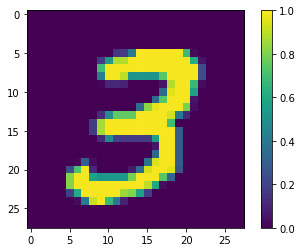

In [7]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [0]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

True


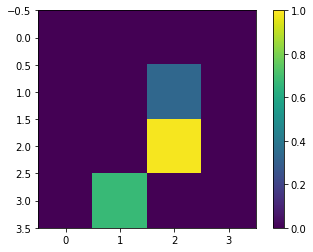

In [9]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [0]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
      labels = mapping[tuple(x.flatten())]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(list(labels)[0])
      else:
          # Throw out images that match more than one label.
          pass
    
    num_3 = sum(1 for value in mapping.values() if True in value)
    num_6 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 3s: ", num_3)
    print("Number of 6s: ", num_6)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

In [11]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of 3s:  4961
Number of 6s:  5475
Number of contradictory images:  49

Initial number of examples:  12049
Remaining non-contradictory examples:  11520


In [0]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [0]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


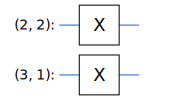

In [14]:
SVGCircuit(x_train_circ[0])

In [15]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

In [0]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [0]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

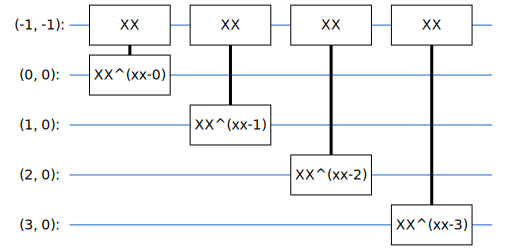

In [18]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [0]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [0]:
model_circuit, model_readout = create_quantum_model()

In [0]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [0]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

In [0]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [0]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [25]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [0]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [0]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3


# Classical neural network

In [0]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

In [0]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

In [0]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

In [0]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

# Comparison

In [0]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])
